In [1]:
import sys
import time
tic = time.time() 
sys.path.insert(1, 'C:\\Users\\Pascal\\Desktop\\TP4a\\git\\TP4_ECAL-\\utils')
sys.path.insert(1, 'C:\\Users\\Pascal\\Desktop\\TP4a\\git_final_final\\ecal_reco\\tracking')
from data_loading import *
from tqdm import tqdm
from hit import Hit
from track3D import Track3D
from matplotlib import pyplot as plt
from track_reconstruction import *

file_path = 'C:\\Users\\Pascal\\Desktop\\TP4a\\data\\run_000002\\data_0000.root' 
import pandas as pd
import uproot
import numpy as np


N_cons_events = 250 # number of events to consider

br_list_data = ['n_hits', 'tofpet_id', 'tofpet_channel', 'timestamp', 't_coarse', 't_fine', 'timestamp', 'v_coarse', 'v_fine', 'value']
br_list_evt = ['timestamp', 'evt_number', 'evt_flags']
evt_tree = 'event_data;1'
hits_tree = 'event_data;1'

with uproot.open(file_path) as tree:
    hits_dict = tree[hits_tree].arrays(br_list_data, library="np")
    evts_dict = tree[evt_tree].arrays(br_list_evt, library="np")
    
df_evts = pd.DataFrame.from_dict(evts_dict)
df_hits = pd.DataFrame.from_dict(hits_dict)
df_hits['timestamp_event'] = df_evts['timestamp']
df_hits = df_hits[0:N_cons_events]

In [2]:
nb_events = len(df_hits['n_hits'])
for index, row in tqdm(df_hits.iterrows(), total = df_hits.shape[0]):
    channels = row['tofpet_channel']
    tofpet_id = row['tofpet_id']
    hits = [Hit(row,i) for i in range(row['n_hits'])]
    hitsX = [h for h in hits if h.is_sidex]
    hitsY = [h for h in hits if not h.is_sidex]

100%|██████████| 250/250 [00:00<00:00, 655.81it/s]


In [3]:
pos = []
for i in range(len(hits)):
    pos.append(hits[i].get_pos())
print(len(pos))

17


In [4]:
def dist_from_curve(theta, gamma, x0, x1, isx):
    if(isx):
        return np.abs(-np.tan(theta)*np.sin(gamma)*(x1[1]-x0[2])+x0[0]-x1[0])
    else:
        return np.abs(-np.tan(theta)*np.cos(gamma)*(x1[1]-x0[2])+x0[1]-x1[0])
    
def error_fit(theta,gamma,x0,hits):
    error = 0
    for i in range(len(hits)):
        error += dist_from_curve(theta,gamma,x0,hits[i].get_pos(),hits[i].is_sidex)
    return error

def error_matrix(Hits,theta_vec,gamma_vec,x0,y0,z0):
    Matrix = np.ndarray(shape=(len(theta_vec),len(gamma_vec),len(x0),len(y0)), dtype=float)
    pos = []
    t = time.time()
    for i in range(len(theta_vec)):
        t = time.time()
        for j in range(len(gamma_vec)):
            for k in range(len(x0)):
                for l in range(len(y0)):
                    Matrix[i][j][k][l] = error_fit(theta_vec[i],gamma_vec[j],[x0[k],y0[l],z0],Hits)
        t2 = time.time()-t
    print('"error_fit" duration',t2/(len(x0)*len(y0)*len(gamma_vec)),'s')
    return Matrix

def find_3Dcurve(Hits, Nbr_It = 2):
     # Finds the highest cell of index idmax
    import time
    Max = 0
     # number of time the iteration is ran
    for i in range(len(Hits)):
        if(Hits[i].get_pos()[1]>Max):
            idmax = i
            Max = Hits[i].get_pos()[1]

    X0 = Hits[idmax]
    z0 = X0.get_pos()[1]
    # generate the grid
    
    theta = np.linspace(0,0.9*np.pi*0.5,5)
    gamma = np.linspace(0,np.pi*2,5)
    if(X0.is_sidex):
        x0 = np.linspace(X0.get_pos()[0]-0.8,X0.get_pos()[0]+0.8,5)
        y0 = np.linspace(0,38.4,5*24)
    else:
        y0 = np.linspace(X0.get_pos()[0]-0.8,X0.get_pos()[0]+0.8,5)
        x0 = np.linspace(0,38.4,5*24)
    
    # first approx in the whole bar
    
    M = error_matrix(Hits,theta,gamma,x0,y0,z0)
    
    idx=np.unravel_index(np.argmin(M, axis=None), M.shape)

    # iteration

    dt = theta[1]-theta[0]
    dg = gamma[1]-gamma[0]
    dx = x0[1]-x0[0]

    for i in range(Nbr_It):
        dt = dt/5
        dg = dg/5
        dx = dx/5

        #new grid
        theta = np.linspace(theta[idx[0]]-dt,theta[idx[0]]+dt,5)
        gamma = np.linspace(gamma[idx[1]]-dg,gamma[idx[1]]+dg,5)
        x0    = np.linspace(x0[idx[2]]-dx,x0[idx[2]]+dx,5)
        y0    = np.linspace(y0[idx[3]]-dx,y0[idx[3]]+dx,5)

        M = error_matrix(Hits,theta,gamma,x0,y0,z0)
        idx=np.unravel_index(np.argmin(M, axis=None), M.shape)
    return [theta[idx[0]], gamma[idx[1]],x0[idx[2]],y0[idx[3]],z0,M[idx]]

In [6]:

RETURN = find_3Dcurve(hits,3)

"error_fit" duration 9.908183415730795e-05 s
"error_fit" duration 0.0001034069061279297 s
"error_fit" duration 0.00012769889831542967 s
"error_fit" duration 0.00011966896057128906 s


[20.000268907563022, 9.925136134453782, 15.200000000000001]
[0.0, 0.34479037489159314, -0.9386797096891542]


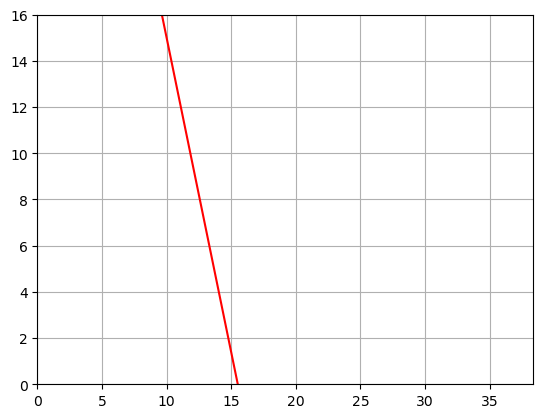

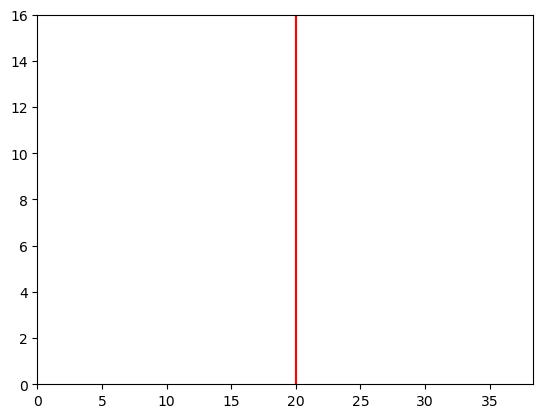

In [31]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

X0 = [RETURN[2],RETURN[3],RETURN[4]]
theta = RETURN[0]
gamma = RETURN[1]


a = [np.sin(gamma)*np.sin(theta),np.cos(gamma)*np.sin(theta),-np.cos(theta)]
tt = np.linspace((16-X0[2])/a[2],-X0[2]/a[2],1000)

print(X0)
print(a)
xx = X0[0]+a[0]*tt
yy = X0[1]+a[1]*tt
zz = X0[2]+a[2]*tt

fig = plt.figure()
ax = plt.axes()
# ax = plt.axes(projection='3d')
ax.set_xlim(0,38.4)
ax.set_ylim(0,16)
ax.grid()
# ax.set_zlim(0,20)
plt.plot(yy,zz,'r-')

fig = plt.figure()
ax = plt.axes()
ax.set_xlim(0,38.4)
ax.set_ylim(0,16)
ax.grid()
# ax.set_zlim(0,20)
plt.plot(xx,zz,'r-')





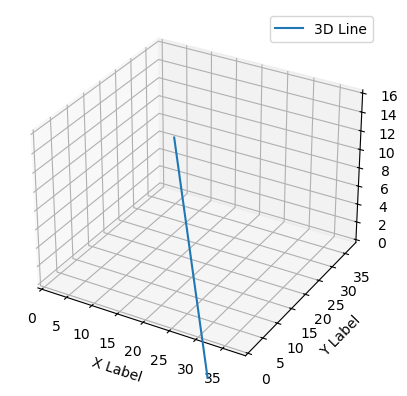

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create some sample data for the line

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the line in 3D
ax.plot(xx, yy, zz, label='3D Line')

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
# Set custom axis limits
ax.axis('equal')
ax.set_xlim(0, 38.4)  # Set limits for the X axis
ax.set_ylim(0, 38.4)  # Set limits for the Y axis
ax.set_zlim(0, 16)  # Set limits for the Z axis
# Add a legend
ax.legend()

# Show the plot
plt.show()